In [1]:
########################################################### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflow
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src')
from data_preparation import get_birth_data, plot_data, separate_data

########################################################### DATA
data = get_birth_data()
un_x, un_y = separate_data(data)
un_x_w, un_y_w = separate_data(data, weekdays=True)
x, y = separate_data(data, normalised=True)
x_w, y_w = separate_data(data, normalised=True, weekdays=True)

2022-06-23 14:50:51.244732: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-23 14:50:51.827446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9327 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [2]:
# for xlabels (xticks)
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs

In [3]:
def gp_fit_pred(x, y, k, title, zoom_in=None, pos=None, labels=None, trainable=None):
    
    gp = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)

    if trainable:
        try:
            set_trainable(gp.kernel.kernels[0].period, False)
        except: 
            print("No period parameter present")

        set_trainable(gp.likelihood.variance , False)
        print('Initial Model Summary')
        print_summary(gp, fmt="notebook")
        print('log-marginal likelihood', gp.log_marginal_likelihood().numpy())
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables)
    print('Optimisation Summary')
    print_summary(gp, fmt="notebook")
    print('Objective for maximum likelihood estimation', gp.maximum_log_likelihood_objective().numpy())
    
    mu, var = gp.predict_f(x)
    print('predictive variance', np.mean(var))
    plt.figure(figsize=(20,5))
    plt.plot(x, y, '.', label='true data', c='black', markersize=2)
    plt.plot(x, mu, '-', label='pred', c='C0', linewidth=3)
    vv = 1.96 * np.sqrt(var)
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='C0')
    plt.title(title); plt.xlabel('Years'); plt.ylabel('Normalised births'); plt.xticks(pos, labels)
    
    if zoom_in:
        plt.figure(figsize=(20,5))
        plt.plot(x[:100], y[:100], '.', label='true data', c='black', markersize=4)
        plt.plot(x[:100], mu[:100], '-', label='pred', c='C0', linewidth=2)
        vv = 1.96 * np.sqrt(var)
        plt.fill_between(x[:100,0], (mu-vv)[:100,0], (mu+vv)[:100,0], alpha=0.2, edgecolor='gray', facecolor='C0')
        plt.title(title + ' + zoom_in')
    
    return opt_logs


No period parameter present
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


tf.Tensor(-10313.268536051373, shape=(), dtype=float64)
Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.375142
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.23918
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Objective for maximum likelihood estimation tf.Tensor(-9778.918001179252, shape=(), dtype=float64)
predictive variance 0.16283346882097155


      fun: 9778.918001179252
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00040276, -0.00034086])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 13
      nit: 9
     njev: 13
   status: 0
  success: True
        x: array([ 2.12651633, -0.78702283])

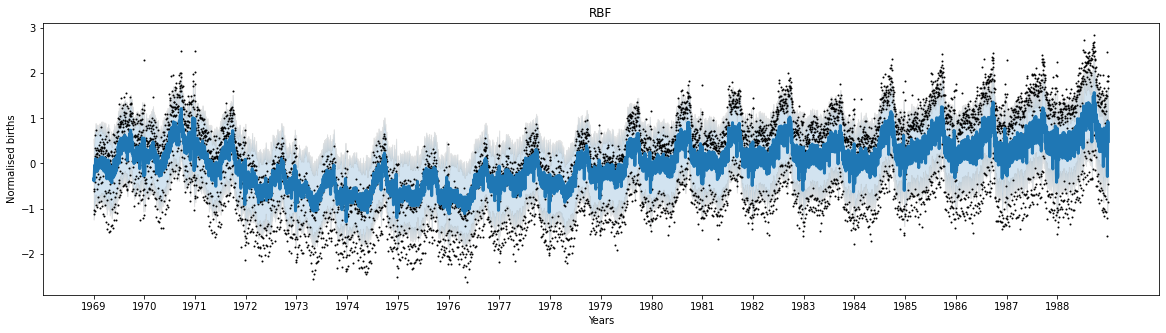

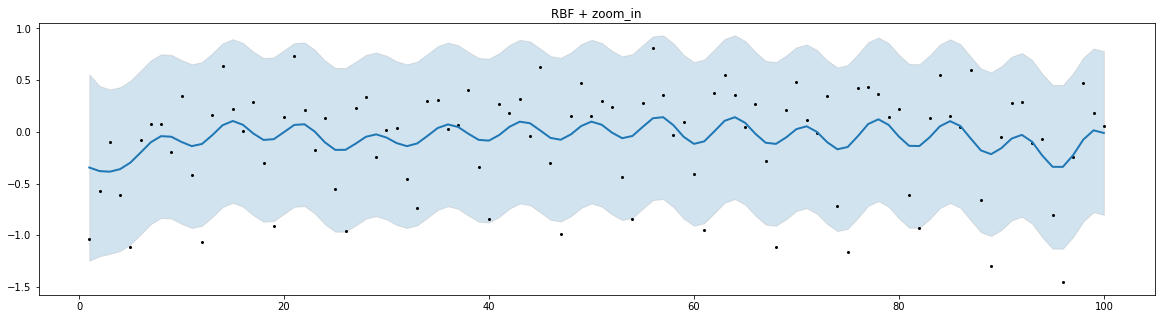

In [7]:
pos, labels = get_xticks(data)
k = gpflow.kernels.RBF()
gp_fit_pred(x, y, k, zoom_in=True, title='RBF', pos=pos, labels=labels, trainable=True)

Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.651321
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.907521
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.390243
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,151.484
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Objective for maximum likelihood estimation tf.Tensor(-7148.201172206225, shape=(), dtype=float64)
predictive variance 9.999952567483048e-07


      fun: 7148.201172206225
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.72048848e-002, -2.51817486e-002,  3.06499959e-005,
       -1.49687183e-003,  2.89818725e-110])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 41
      nit: 37
     njev: 41
   status: 0
  success: True
        x: array([ 3.90806698e-01, -8.54785777e-02,  1.51483664e+02, -7.39528130e-01,
       -2.59544010e+02])

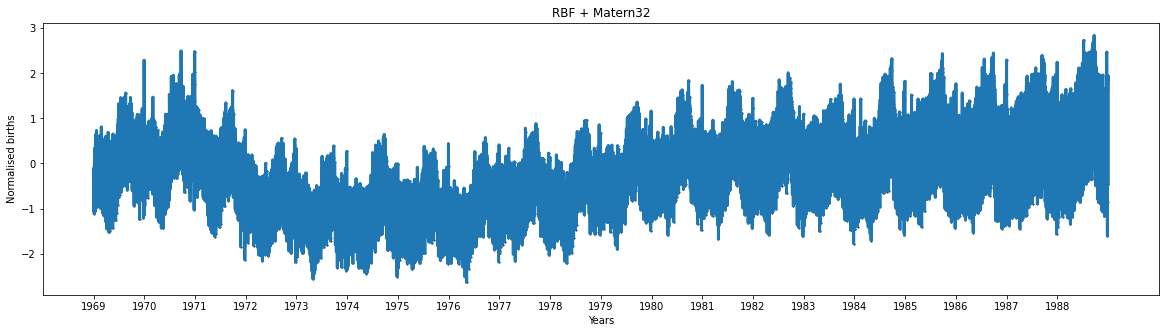

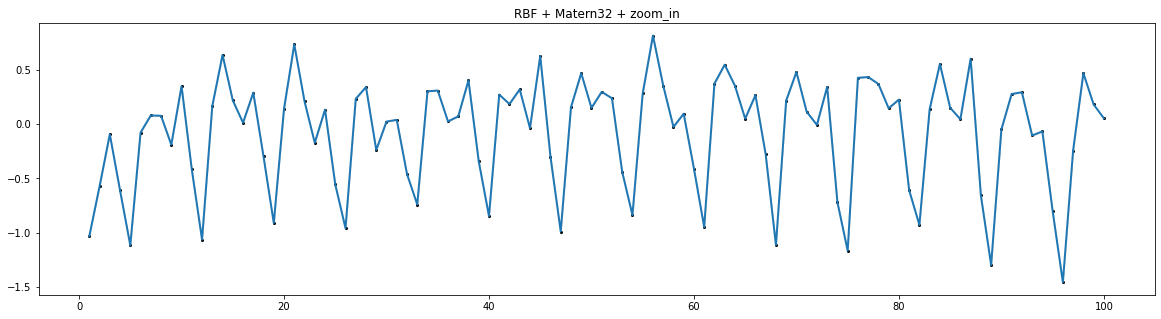

In [8]:
pos, labels = get_xticks(data)
k = gpflow.kernels.RBF() + gpflow.kernels.Matern32()
gp_fit_pred(x, y, k, zoom_in=True, title='RBF + Matern32', pos=pos, labels=labels)

No period parameter present
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


tf.Tensor(-11136.573949019592, shape=(), dtype=float64)
Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.26643e-14
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,20.8579
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.401765
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,143.264
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Objective for maximum likelihood estimation tf.Tensor(-8923.738063279867, shape=(), dtype=float64)
predictive variance 0.013930539946647785


      fun: 8923.738063279867
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.28437996e-12,  1.24596417e-11,  4.85090773e-06, -6.38450002e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 19
     njev: 24
   status: 0
  success: True
        x: array([ 20.85792515, -31.41798549, 143.26438799,  -0.70428875])

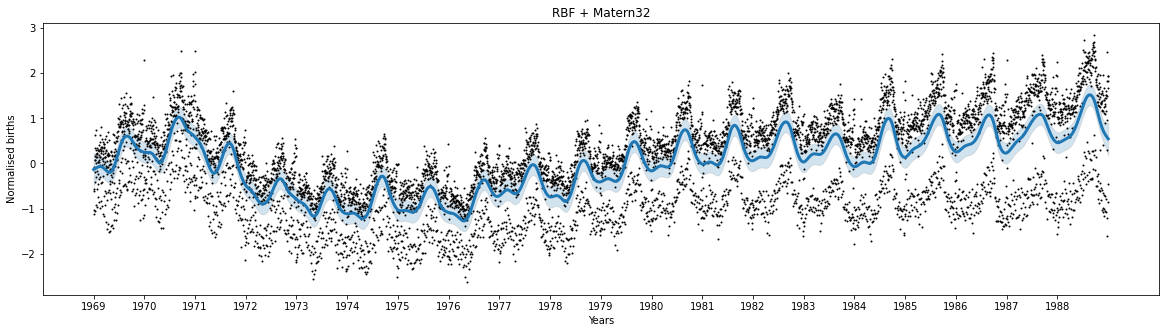

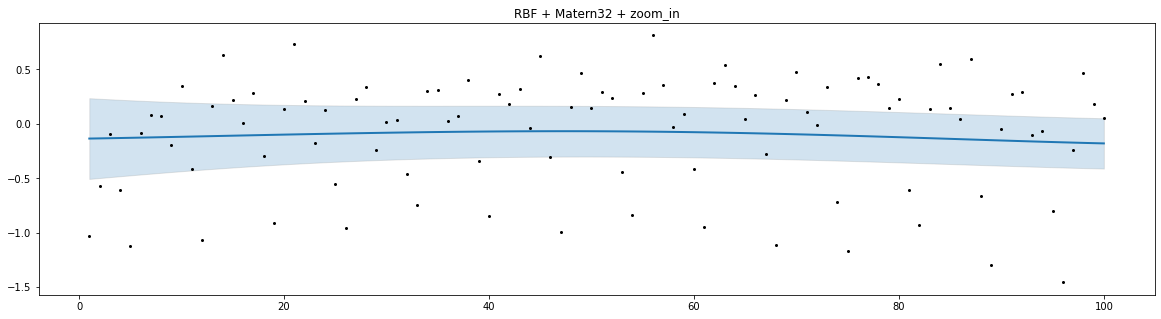

In [9]:
k = gpflow.kernels.RBF() + gpflow.kernels.Matern32()
gp_fit_pred(x, y, k, zoom_in=True, title='RBF + Matern32', pos=pos, labels=labels, trainable=True)

Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


log-marginal likelihood -10233.076354801557
Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.0817399
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.256295
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.293209
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.10058
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Objective for maximum likelihood estimation -9674.2724860553
predictive variance 0.14870561525282533


      fun: 9674.2724860553
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.64517838e-04, 3.03172512e-04, 1.67254099e-05, 1.30373206e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 25
     njev: 32
   status: 0
  success: True
        x: array([-1.23054424, -2.46306456,  1.97003477, -1.07668539])

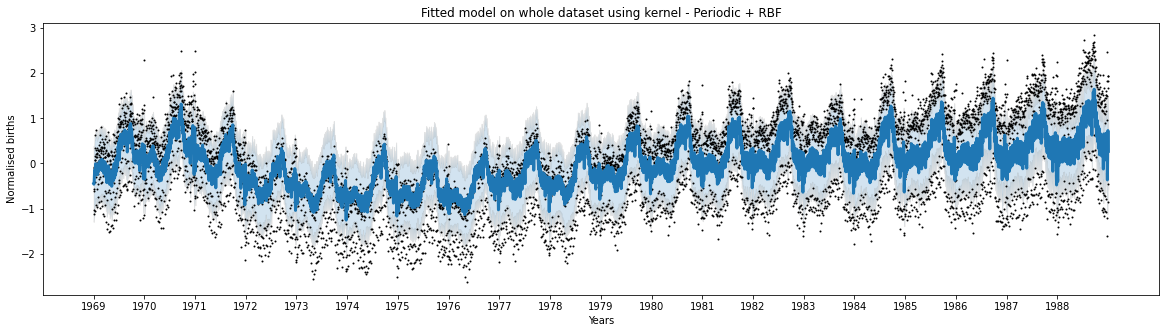

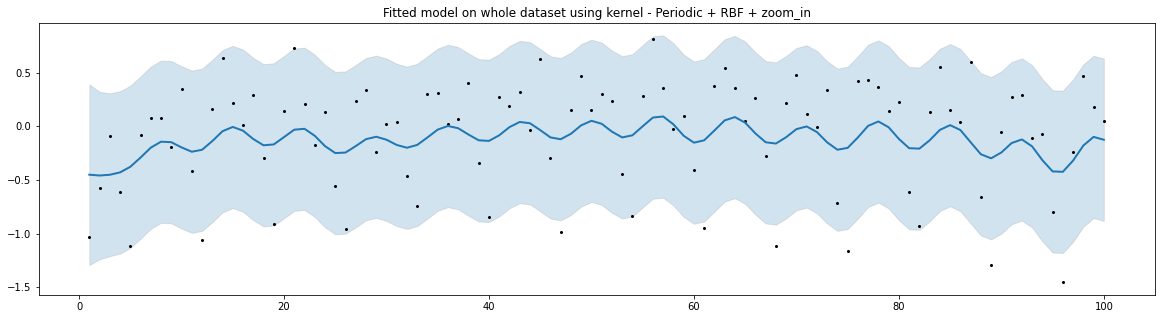

In [6]:
pos, labels = get_xticks(data)
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_fit_pred(x, y, k, zoom_in=True, title='Fitted model on whole dataset using kernel - Periodic + RBF', trainable=True, pos=pos, labels=labels)

#### Un-normalised

In [ ]:
pos, labels = get_xticks(data)
k = gpflow.kernels.RBF()
gp_fit_pred(un_x, un_y, k, zoom_in=True, title='UN-NORMALISED: RBF', pos=pos, labels=labels, trainable=True)

In [ ]:
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_fit_pred(un_x, un_y, k, zoom_in=True, title='UN-NORMALISED: Periodic(RBF) + RBF', trainable=True)

In [ ]:
k = gpflow.kernels.RBF() + gpflow.kernels.Matern32()
gp_fit_pred(un_x, un_y, k, zoom_in=True, title='UN-NORMALISED: RBF + Matern32', pos=pos, labels=labels, trainable=True)

In [ ]:
k = gpflow.kernels.RBF() + gpflow.kernels.Matern32()
gp_fit_pred(un_x, un_y, k, zoom_in=True, title='UN-NORMALISED: RBF + Matern32', pos=pos, labels=labels)

# WEEKDAYS

In [4]:
data_weekdays = data.loc[data.weekday==1]
pos, labels = get_xticks(data_weekdays)

Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.109887
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0265381
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.43279
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,452.276
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


predictive varaince 0.018427315677706592


      fun: 5230.41902582749
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.67511487e-04, -2.86935434e-04,  3.24884383e-07,  3.94862201e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 32
     njev: 40
   status: 0
  success: True
        x: array([ -3.61587611,  -2.15285863, 452.27565073,  -0.61331533])

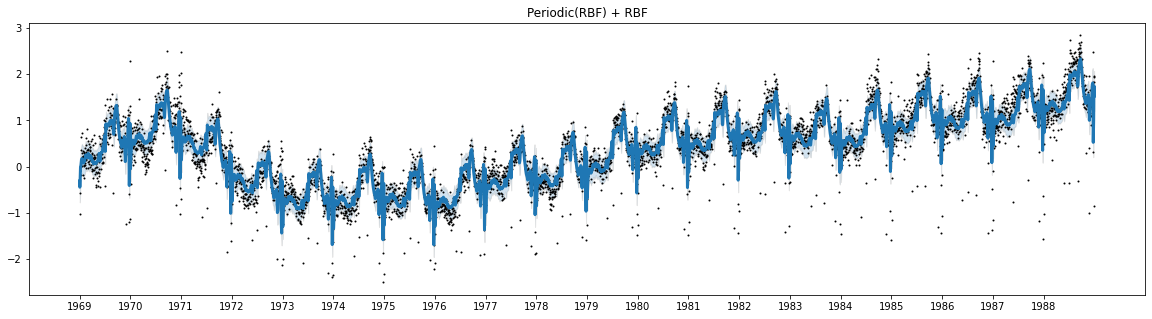

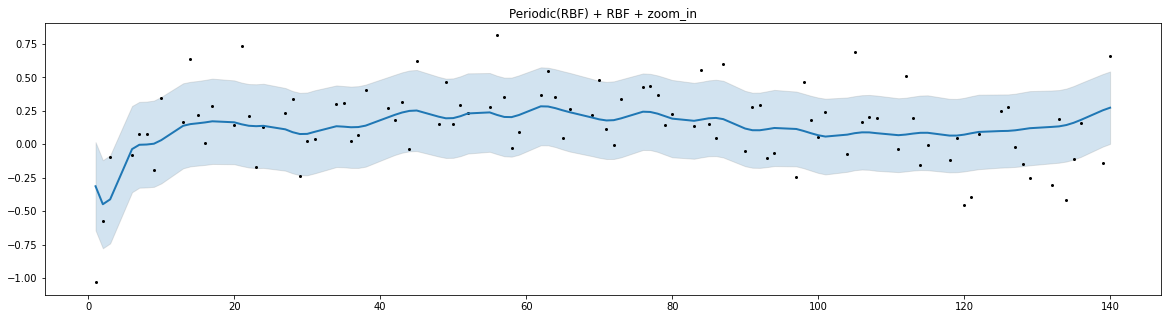

In [ ]:
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_fit_pred(x_w, y_w, k, zoom_in=True, title='Periodic(RBF) + RBF', trainable=True, pos=pos, labels=labels)

In [ ]:
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_fit_pred(un_x_w, un_y_w, k, zoom_in=True, title='UN-NORMALISED + WEEKDAY: Periodic(RBF) + RBF', trainable=True, pos=pos, labels=labels)

# Random data split

In [5]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_train = df_train.sort_values(by='ids')
df_test = df_test.sort_values(by='ids')

x_train, y_train = separate_data(df_train, normalised=True)
x_w_train, y_w_train = separate_data(df_train, normalised=True, weekdays=True)
x_test, y_test = separate_data(df_test, normalised=True)
x_w_test, y_w_test = separate_data(df_test, normalised=True, weekdays=True)

x_train, y_train = separate_data(df_train, normalised=True)
x_w_train, y_w_train = separate_data(df_train, normalised=True, weekdays=True)
x_test, y_test = separate_data(df_test, normalised=True)
x_w_test, y_w_test = separate_data(df_test, normalised=True, weekdays=True)

In [6]:
def gp_split_fit_pred(x, y, k, title, x_test=None, y_test=None, pos=None, labels=None, trainable=None):

    diagnostics = {
        "Initial likelihood": 0,
        "Obj Likelihood": 0,
        "Avg predictive variance": 0,
        "MSE Train": 0,
        "MSE Test": 0
    }
    
    gp = gpflow.models.GPR(data=(x, y), kernel=k, mean_function=None)

    if trainable:
        try:
            set_trainable(gp.kernel.kernels[0].period, False)
        except: 
            print("No period parameter present")
        set_trainable(gp.likelihood.variance , False)
        print('Initial Model Summary')
        print_summary(gp, fmt="notebook")
        diagnostics["Initial likelihood"] = gp.log_marginal_likelihood().numpy()
    
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(gp.training_loss, gp.trainable_variables)
    print('Optimisation Summary')
    print_summary(gp, fmt="notebook")
    diagnostics["Obj Likelihood"] = gp.maximum_log_likelihood_objective().numpy()
    
    mu, var = gp.predict_f(x)
    diagnostics["Avg predictive variance"] = np.mean(var)
    diagnostics['MSE Train'] = mean_squared_error(y, mu)

    plt.figure(figsize=(20,5))
    plt.plot(x, y, '.', label='train data', c='black', markersize=3)
    plt.plot(x, mu, '-', label='Train - mean predictive posterior', c='C0', linewidth=3)
    vv = 1.96 * np.sqrt(var) 
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.4, edgecolor='gray', facecolor='C0')
    plt.title('Train data with kernel: ' + title)
    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Births')
    plt.legend()
    plt.show()
        
    if x_test is not None:
        mu_test, var_test = gp.predict_f(x_test)
        diagnostics['MSE Test'] = mean_squared_error(y_test, mu_test)
        plt.figure(figsize=(20,5))
        plt.plot(x_test, y_test, 'x', label='test data', c='red', markersize=4)
        plt.plot(x_test, mu_test, '-', label='Test - mean predictive posterior', c='C0', linewidth=3)
        vv = 1.96 * np.sqrt(var_test) 
        plt.fill_between(x_test[:,0], (mu_test-vv)[:,0], (mu_test+vv)[:,0], alpha=0.4, edgecolor='gray', facecolor='C0')
        plt.title('Test data with kernel: ' + title)
        plt.xlabel('Date')
        plt.ylabel('Births')
        plt.xticks(pos, labels)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(20,5))
        plt.plot(x, y, '.', label='train data', c='black', markersize=3, alpha=0.5)
        plt.plot(x_test, y_test, 'x', label='test data', c='red', markersize=4, alpha=0.5)
        plt.plot(x_test, mu_test, '-', label='Test - mean predictive posterior', c='C0', linewidth=2)
        plt.fill_between(x_test[:,0], (mu_test-vv)[:,0], (mu_test+vv)[:,0], alpha=0.4, edgecolor='gray', facecolor='C0')
        plt.title('Test & Train data with kernel: ' + title)
        plt.xticks(pos, labels)
        plt.xlabel('Date')
        plt.ylabel('Births')
        plt.legend()
        plt.show()
    
    print(pd.DataFrame(diagnostics.items()))
    return opt_logs

Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.0806147
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.150085
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.260943
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,424.68
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


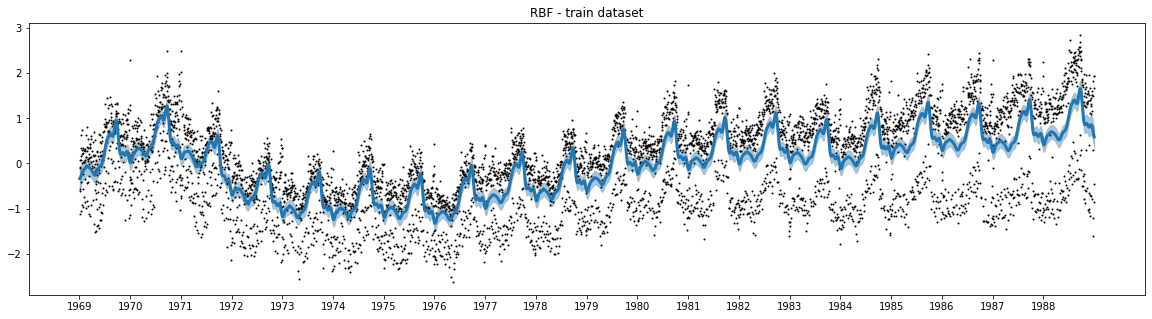

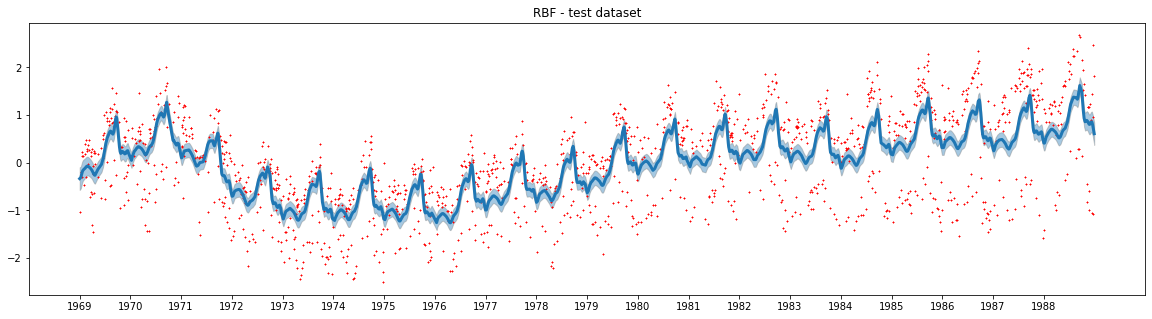

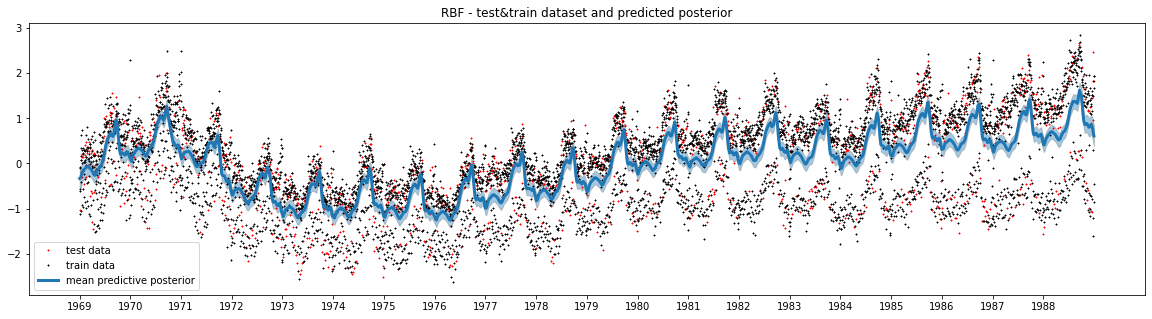

                         0            1
0       Initial likelihood -8287.534331
1           Obj Likelihood -7061.049397
2  Avg predictive variance     0.006214
3                MSE Train     0.551586
4                 MSE Test     0.567032


      fun: 7061.049396558409
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.60903564e-04,  2.07406775e-04,  3.89900467e-06,  7.22171944e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 49
      nit: 35
     njev: 49
   status: 0
  success: True
        x: array([ -1.82057459,  -2.47749583, 424.679805  ,  -1.21014567])

In [31]:
pos, labels = get_xticks(data)
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_split_fit_pred(x_train, y_train, k, title='RBF', x_test=x_test, y_test=y_test, pos=pos, labels=labels, trainable=True)

#### WEEKDAY

2022-06-21 18:51:57.097118: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-21 18:52:00.188654: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x84c9690


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.98858e-11
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,8.75301
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.603846
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,77.7517
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.130727


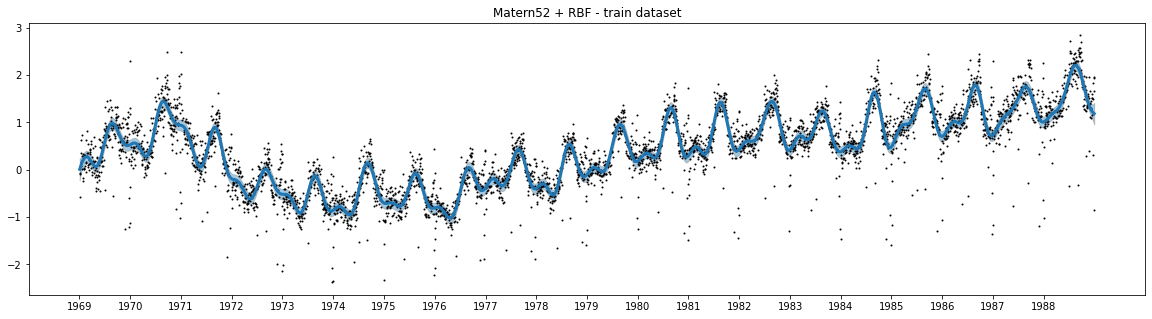

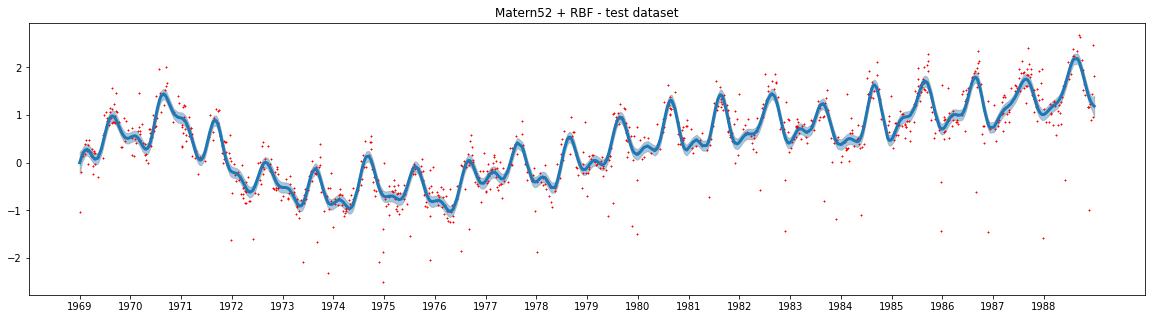

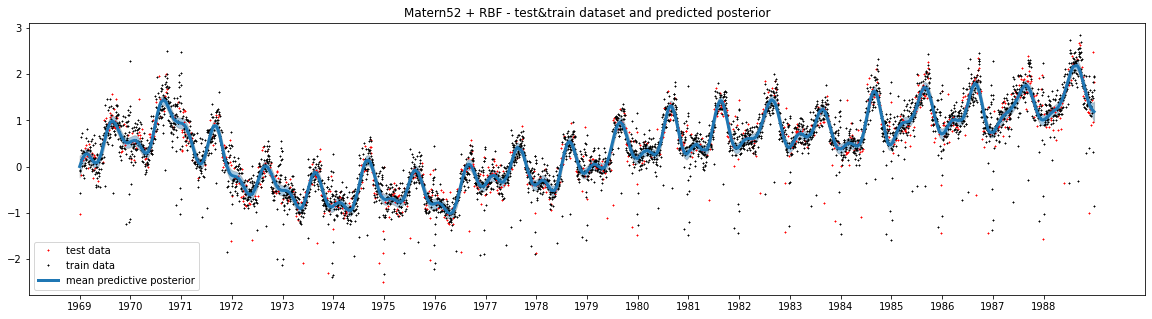

                         0            1
0       Initial likelihood     0.000000
1           Obj Likelihood -1905.929045
2  Avg predictive variance     0.003305
3                MSE Train     0.127422
4                 MSE Test     0.148844


      fun: 1905.9290450419971
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.40656264e-09, -1.86675392e-07,  1.46507454e-05, -2.18482107e-04,
        6.86027765e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 20
     njev: 27
   status: 0
  success: True
        x: array([  8.75285296, -24.23363736,  77.75169957,  -0.18736656,
        -1.96857919])

In [8]:
data_weekdays = data.loc[data.weekday==1]
pos, labels = get_xticks(data_weekdays)
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_split_fit_pred(x_w_train, y_w_train, k, title='Matern52 + RBF', x_test=x_w_test, y_test=y_w_test, pos=pos, labels=labels)

No period parameter present
Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,6.50428e-07
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,39.2715
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.532531
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,83.8377
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


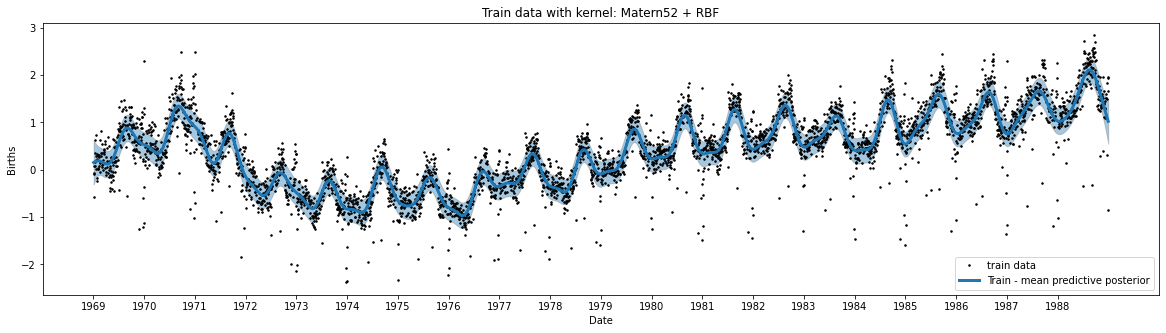

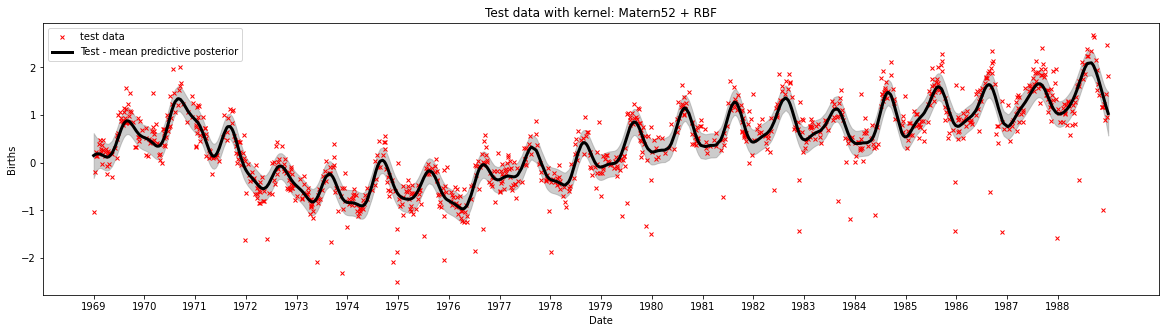

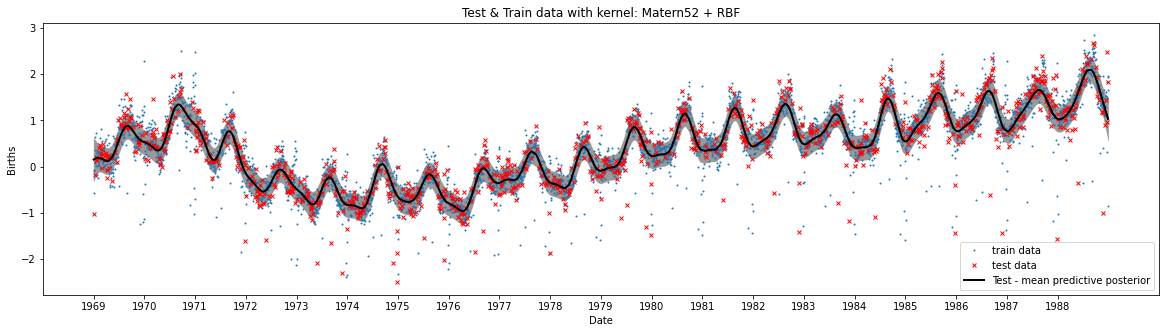

                         0            1
0       Initial likelihood -6331.674759
1           Obj Likelihood -4276.928382
2  Avg predictive variance     0.018773
3                MSE Train     0.134229
4                 MSE Test     0.159047


      fun: 4276.928382230085
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.24136588e-06,  1.27657450e-04,  5.05437161e-04, -1.72651620e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 34
      nit: 29
     njev: 34
   status: 0
  success: True
        x: array([ 39.27145361, -14.24563465,  83.83765563,  -0.35205971])

In [28]:
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_split_fit_pred(x_w_train, y_w_train, k, title='Matern52 + RBF', x_test=x_w_test, y_test=y_w_test, pos=pos, labels=labels, trainable=True)

Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.0968153
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.111795
GPR.kernel.kernels[0].period,Parameter,Softplus,,True,(),float64,365.297
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.354801
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,157.406
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.118144


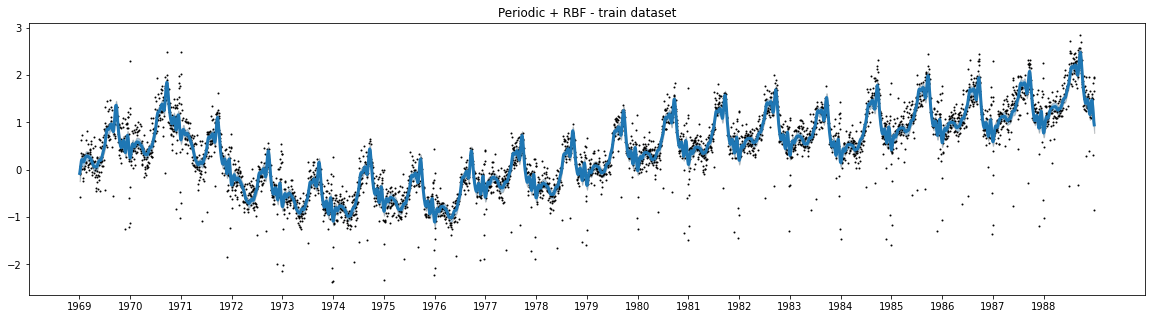

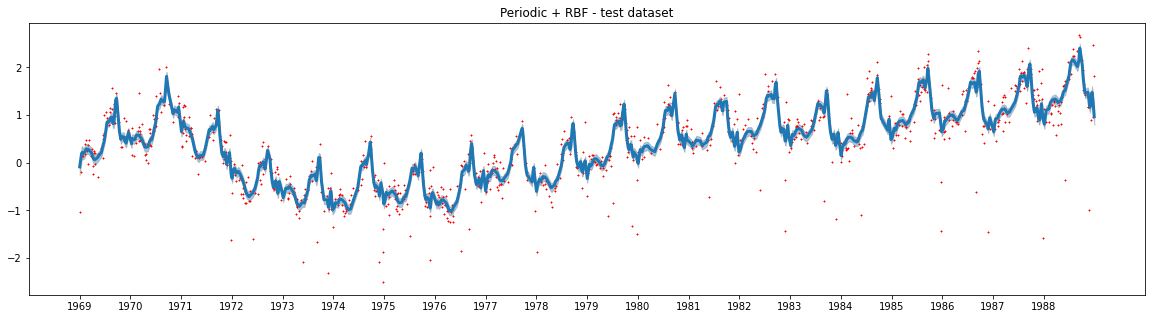

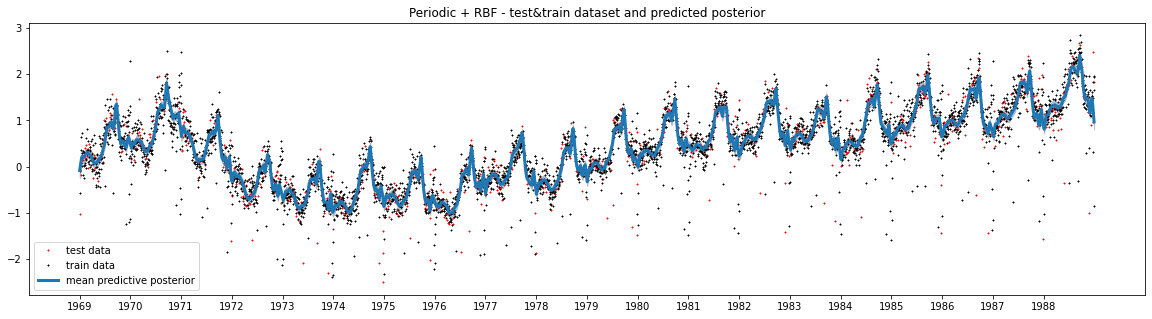

                         0            1
0       Initial likelihood     0.000000
1           Obj Likelihood -1641.820523
2  Avg predictive variance     0.002300
3                MSE Train     0.115844
4                 MSE Test     0.131361


      fun: 1641.8205231621523
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.60019767e-04, -6.89156557e-04,  1.37448264e-04, -2.20081789e-06,
        1.10326414e-04,  1.54034374e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 47
     njev: 69
   status: 0
  success: True
        x: array([365.29688432,  -2.13466731,  -2.28615213, 157.4056539 ,
        -0.85355926,  -2.0762065 ])

In [14]:
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_split_fit_pred(x_w_train, y_w_train, k, title='Periodic + RBF', x_test=x_w_test, y_test=y_w_test, pos=pos, labels=labels)

In [17]:
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_split_fit_pred(x_w_train, y_w_train, k, title='Periodic + RBF', x_test=x_w_test, y_test=y_w_test, pos=pos, labels=labels, trainable=True)

Initial Model Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].period,Parameter,Softplus,,False,(),float64,365.25
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1


KeyboardInterrupt: 

### UN-NORMALISED

In [7]:
x_train, y_train = separate_data(df_train)
x_w_train, y_w_train = separate_data(df_train, weekdays=True)
x_test, y_test = separate_data(df_test)
x_w_test, y_w_test = separate_data(df_test, weekdays=True)

x_train, y_train = separate_data(df_train)
x_w_train, y_w_train = separate_data(df_train, weekdays=True)
x_test, y_test = separate_data(df_test)
x_w_test, y_w_test = separate_data(df_test, weekdays=True)

In [ ]:
pos, labels = get_xticks(data)
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_split_fit_pred(x_train, y_train, k, title='UN-NORMALISED: RBF', x_test=x_test, y_test=y_test, pos=pos, labels=labels)

In [ ]:
pos, labels = get_xticks(data)
k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
gp_split_fit_pred(x_w_train, y_w_train, k, title='UN-NORMALISED + WEKKDAY: Matern52 + RBF', x_test=x_w_test, y_test=y_w_test, pos=pos, labels=labels)

2022-06-23 14:51:30.755644: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-23 14:51:34.007583: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8b88900


Optimisation Summary


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,83133.7
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,8.3197e-144
GPR.kernel.kernels[0].period,Parameter,Softplus,,True,(),float64,1665.6
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,612280
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,74.9905
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,82949.6


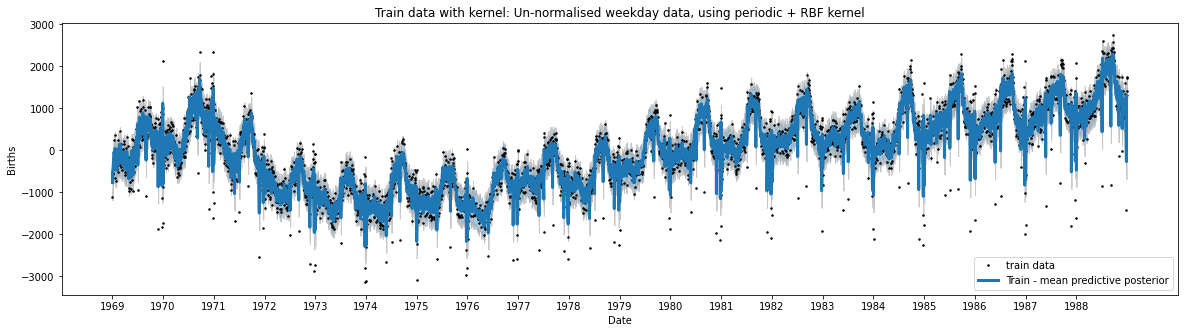

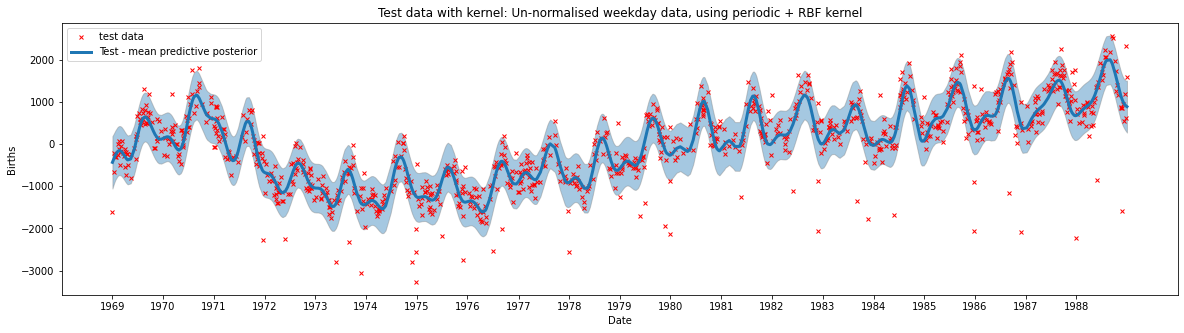

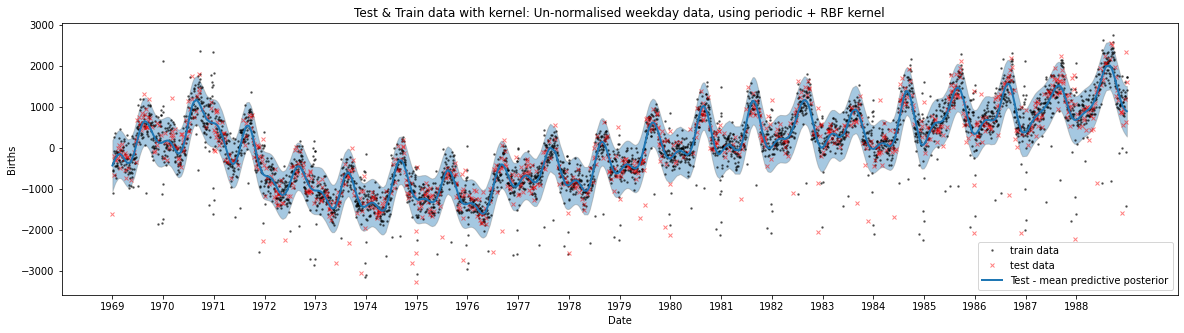

                         0              1
0       Initial likelihood       0.000000
1           Obj Likelihood  -31246.723281
2  Avg predictive variance   42581.535198
3                MSE Train   40367.714304
4                 MSE Test  188962.171453


      fun: 31246.723280570885
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  1.09049790e-07, -7.44802892e-05,
       -8.62485880e-10,  1.09049790e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 61
     njev: 88
   status: 0
  success: True
        x: array([ 1.66560315e+03, -3.29453628e+02,  8.31336995e+04,  7.49904689e+01,
        6.12280147e+05,  8.29496089e+04])

In [8]:
k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
gp_split_fit_pred(x_w_train, y_w_train, k, title='Un-normalised weekday data, using periodic + RBF kernel', x_test=x_w_test, y_test=y_w_test, pos=pos, labels=labels)